tensorboard --logidr=./show

In [1]:
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
CHAR_NUM = len(number) + len(alphabet) + len(ALPHABET)

FLAG_CHAR = 1 # 0:fixed length; 1:variable lenght
CHAR_LEN = 4
MIN_CHAR_LEN = 4
MAX_CHAR_LEN = 6

IMAGE_HEIGHT = 60
IMAGE_WIDTH = 160

CHANNEL = 1

NUM_CNN_LAYERS = 3
CONV_FILTERS = 32
KERNEL_SIZE = 3
POOL_SIZE = 2

DENSE_SIZE = 256
DROPOUT_RATE = 0.5

address_tensorboard = 'show/'
address_model = 'best_model.hdf5'

In [44]:
from captcha.image import ImageCaptcha
from PIL import Image
import random
import string

def get_char_length_and_number():
    if FLAG_CHAR == 0:
        char_len = CHAR_LEN
        char_num = CHAR_NUM
    elif FLAG_CHAR == 1:
        char_len = MAX_CHAR_LEN
        char_num = CHAR_NUM + 1
    else:
        raise ValueError(u'FLAG_CHAR should be 0 or 1')
        char_len = -1
    return char_len,char_num
    
def make_rand_char():
    return random.choice(string.ascii_letters+'0123456789')

def make_rand_text(length):
    text = ''
    for i in range(length):
        rand_char = ''
        r_char = make_rand_char()
        rand_char += r_char
        text += rand_char
    return text

def make_rand_image(text):
    image = ImageCaptcha()
    image = Image.open(image.generate(text))
    return image

def char2pos(c):
    if c >= '0' and c <= '9':
        k = ord(c) - ord('0')
    elif c >= 'a' and c <= 'z':
        k = ord(c) - ord('a') + 10
    elif c >= 'A' and c <= 'Z':
        k = ord(c) - ord('A') + 36
    elif c == '' or c == ' ':
        k = 62
    else:
        print ('character not in lists')
    return k

def pos2char(char_idx):
    if char_idx == -1:
        char = ''
    elif char_idx == 62:
        char = ''
    elif char_idx < 10:
        char = chr(int(char_idx + ord('0')))
    elif char_idx < 36:
        char = chr(int(char_idx - 10 + ord('a')))
    elif char_idx < 62:
        char = chr(int(char_idx - 36 + ord('A')))
    else:
        raise ValueError('error')
    return char

def text2index(text):
    index = []
    for i in text:
        text_index = char2pos(i)
        index.append(text_index)
    return index

def index2text(vec):
    text = ''
    for i in vec:
        char_code = pos2char(i)
        text += char_code
    return "".join(text)

def text2vec(text):
    text_len = len(text)
    char_len,char_num = get_char_length_and_number()
    
    if text_len > char_len:
        raise ValueError(u'Text length does not fit')

    vector = np.zeros(char_len * char_num)
    for i in range(char_len):
        if i < text_len:
            idx = i * char_num + char2pos(text[i])
        else:
            idx = i * char_num + char2pos('')
        vector[idx] = 1        
    return vector

def vec2text(vec):
    char_len,char_num = get_char_length_and_number()
    vec = np.array(vec).flatten()
    char_pos = vec.nonzero()[0]
    text = []
    for i, c in enumerate(char_pos):
        char_at_pos = i  # c/63
        char_idx = c % char_num
        char_code = pos2char(char_idx)
        text.append(char_code)
    return "".join(text)

def pred2text(pred):
    char_len,char_num = get_char_length_and_number()
    pred = np.array(pred)
    pred = np.reshape(pred,[-1,char_num])
    length = pred.shape[0]
    text = []
    for i in range(length):
        pos = np.argmax(pred[i,:])
        text.append(pos2char(pos))
    return "".join(text)

def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    #color = 255 - min(t, 10) * 13 if time_color else 255
    return gray

In [45]:
import numpy as np
from keras.applications.mobilenet import preprocess_input

class Generate_Data():
    
    def __init__(self,train_num=512,val_num=128):
        self.train_num = train_num
        self.val_num = val_num
        [self.char_len,self.char_num] = get_char_length_and_number()    
        
    def next_train(self):
        while True:
            ret = self.get_next_batch(self.train_num)
            yield ret[1:]
            
    def next_val(self):
        while True:
            ret = self.get_next_batch(self.val_num)
            yield ret[1:]
            
    def test(self):
        ret = self.get_next_batch(128)
        image = ret[0]
        x = ret[1]
        y = ret[2]
        return [image,x,y]
    
    def get_next_batch(self,batch_size=128):
        images = np.zeros([batch_size,IMAGE_HEIGHT,IMAGE_WIDTH,3])
        batch_x = np.zeros([batch_size,IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL])
        batch_y = np.zeros([batch_size,self.char_len * self.char_num],dtype='int32')
        flag = 0
        
        while True:
            if FLAG_CHAR == 0:
                text = make_rand_text(self.char_len)
            elif FLAG_CHAR == 1:
                random_len = np.random.randint(MIN_CHAR_LEN,MAX_CHAR_LEN+1)
                text = make_rand_text(random_len)
            image = make_rand_image(text)
            images[flag,:,:,:] = np.reshape(np.array(image),[IMAGE_HEIGHT,IMAGE_WIDTH,3])
            if CHANNEL == 1:
                image = rgb2gray(np.array(image))  
            batch_x[flag,:,:,:] = np.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL])
            batch_y[flag,:] = text2vec(text)
            flag += 1
            if flag >= batch_size:
                break
        batch_x = preprocess_input(batch_x).astype(np.float32)
        batch_y = np.reshape(batch_y,[batch_size,self.char_len,self.char_num])
        inputs = batch_x
        outputs = batch_y
        return images,inputs,outputs

In [46]:
import keras

class MyCbk(keras.callbacks.Callback):
    # for multi-gpu
    def __init__(self, model,logs={}):
        self.model_to_save = model
        self.min_loss = float('Inf')

    def on_epoch_end(self, epoch, logs={}):
        current_loss = logs.get('val_loss')
        if current_loss < self.min_loss:
            self.model_to_save.save(address_model)
            self.min_loss = current_loss
            print (u'val loss improved, new model saved')
        else:
            print (u'val loss does not improve in this epoch')
        

In [47]:
import keras

class Evaluate(keras.callbacks.Callback):
    
    # random show a result in test set
    def __init__(self,val):
        self.x = val[1]
        self.y = val[2]
        
    def on_epoch_end(self,epoch,logs={}):
        
        self.random_index = np.random.randint(self.y.shape[0])
        y_pred = self.model.predict(self.x)
        true = vec2text(self.y[self.random_index,:,:])
        pred = pred2text(y_pred[self.random_index,:,:])
        print ('True: ',true)
        print ('Pred: ',pred)

In [48]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Dense,Reshape,TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.applications import MobileNet
from keras.utils import multi_gpu_model

import os
import datetime

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "11,12"

def accuracy(y_true, y_pred):
    [char_len,char_num] = get_char_length_and_number()    
    y_true = K.reshape(y_true,[-1,char_len,char_num])
    y_pred = K.reshape(y_pred,[-1,char_len,char_num])

    class_true = K.argmax(y_true,axis=2)
    class_pred = K.argmax(y_pred,axis=2)
    
    correct_pred = K.cast(K.equal(class_true,class_pred),tf.int32)
    correct_pred = K.sum(correct_pred,axis=1) # for each position
    correct_pred = K.cast(K.equal(correct_pred,char_len),tf.int32)
    correct_pred = K.cast(K.sum(correct_pred),tf.float32)
    
    accuracy = correct_pred / K.cast(tf.shape(y_true)[0],tf.float32)
    return accuracy


img_gen = Generate_Data(train_num = 128*4)
[char_len,char_num] = get_char_length_and_number()  

input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL)
model = MobileNet(input_shape=input_shape,alpha=1.,weights=None,classes=char_len*char_num)
outputs = model.output
outputs = Reshape((char_len,char_num))(outputs)
Model(inputs=model.input, outputs=outputs).summary()
model = Model(inputs=model.input, outputs=outputs)
    
parallel_model = multi_gpu_model(model, 2)
adam = keras.optimizers.Adam(lr = 0.005, beta_1=0.9, beta_2=0.999,decay=0.01)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[accuracy,categorical_accuracy,categorical_crossentropy])
cbk = MyCbk(model)
tensorboard = TensorBoard(log_dir=address_tensorboard,histogram_freq=0)
eva = Evaluate(img_gen.test())
moniter = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', cooldown=3, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 60, 160, 1)        0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 62, 162, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 80, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 30, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 30, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 32, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 30, 80, 32)        288       
__________

In [50]:
hists = []
hist = parallel_model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 200,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
200/200 [==============================] - 820s 4s/step - loss: 2.8816 - accuracy: 0.0023 - categorical_accuracy: 0.2811 - categorical_crossentropy: 2.8816 - val_loss: 6.4380 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.1445 - val_categorical_crossentropy: 6.4380
val loss improved, new model saved
('True: ', 'xyds9V')
('Pred: ', 'AMbww')
Epoch 2/16
200/200 [==============================] - 855s 4s/step - loss: 0.8222 - accuracy: 0.2417 - categorical_accuracy: 0.7474 - categorical_crossentropy: 0.8222 - val_loss: 6.7693 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.1536 - val_categorical_crossentropy: 6.7693
val loss does not improve in this epoch
('True: ', '6hWlZ')
('Pred: ', '88m8Q')
Epoch 3/16
200/200 [==============================] - 924s 5s/step - loss: 0.2676 - accuracy: 0.6167 - categorical_accuracy: 0.9181 - categorical_crossentropy: 0.2676 - val_loss: 1.5426 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.6966 - val_categorical_crossent

In [51]:
hist = parallel_model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 200,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
200/200 [==============================] - 701s 4s/step - loss: 0.0487 - accuracy: 0.9031 - categorical_accuracy: 0.9825 - categorical_crossentropy: 0.0487 - val_loss: 0.0379 - val_accuracy: 0.9062 - val_categorical_accuracy: 0.9831 - val_categorical_crossentropy: 0.0379
val loss improved, new model saved
('True: ', 'y7hF9')
('Pred: ', 'y7hF9')
Epoch 2/16
200/200 [==============================] - 833s 4s/step - loss: 0.0467 - accuracy: 0.9052 - categorical_accuracy: 0.9831 - categorical_crossentropy: 0.0467 - val_loss: 0.0440 - val_accuracy: 0.8984 - val_categorical_accuracy: 0.9831 - val_categorical_crossentropy: 0.0440
val loss does not improve in this epoch
('True: ', 'laDC5')
('Pred: ', 'laDC5')
Epoch 3/16
200/200 [==============================] - 799s 4s/step - loss: 0.0459 - accuracy: 0.9075 - categorical_accuracy: 0.9834 - categorical_crossentropy: 0.0459 - val_loss: 0.0264 - val_accuracy: 0.9453 - val_categorical_accuracy: 0.9909 - val_categorical_crossentropy: 0.0

In [52]:
hist = parallel_model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 200,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
200/200 [==============================] - 582s 3s/step - loss: 0.0390 - accuracy: 0.9200 - categorical_accuracy: 0.9858 - categorical_crossentropy: 0.0390 - val_loss: 0.0261 - val_accuracy: 0.9297 - val_categorical_accuracy: 0.9883 - val_categorical_crossentropy: 0.0261
val loss does not improve in this epoch
('True: ', 'nU1po')
('Pred: ', 'nU1po')
Epoch 2/16
200/200 [==============================] - 594s 3s/step - loss: 0.0392 - accuracy: 0.9195 - categorical_accuracy: 0.9857 - categorical_crossentropy: 0.0392 - val_loss: 0.0437 - val_accuracy: 0.9219 - val_categorical_accuracy: 0.9870 - val_categorical_crossentropy: 0.0437
val loss does not improve in this epoch
('True: ', 'ZRiZx')
('Pred: ', 'ZRiZx')
Epoch 3/16
200/200 [==============================] - 564s 3s/step - loss: 0.0389 - accuracy: 0.9191 - categorical_accuracy: 0.9856 - categorical_crossentropy: 0.0389 - val_loss: 0.0477 - val_accuracy: 0.8984 - val_categorical_accuracy: 0.9831 - val_categorical_crossentropy

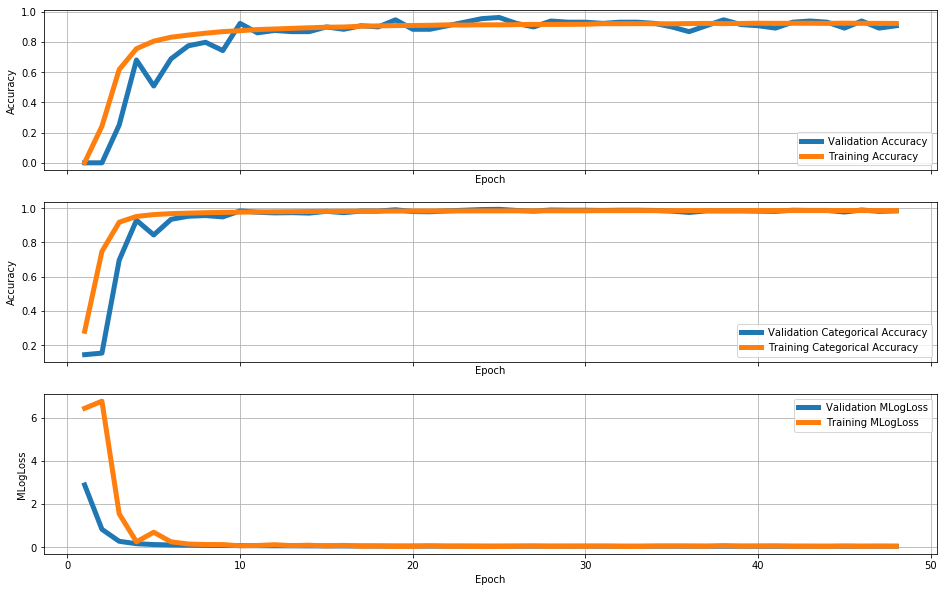

In [55]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 

hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists])
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Categorical Accuracy')
axs[1].plot(hist_df.categorical_accuracy, lw=5, label='Training Categorical Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)

axs[2].plot(hist_df.categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[2].plot(hist_df.val_categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[2].set_ylabel('MLogLoss')
axs[2].set_xlabel('Epoch')
axs[2].grid()
axs[2].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

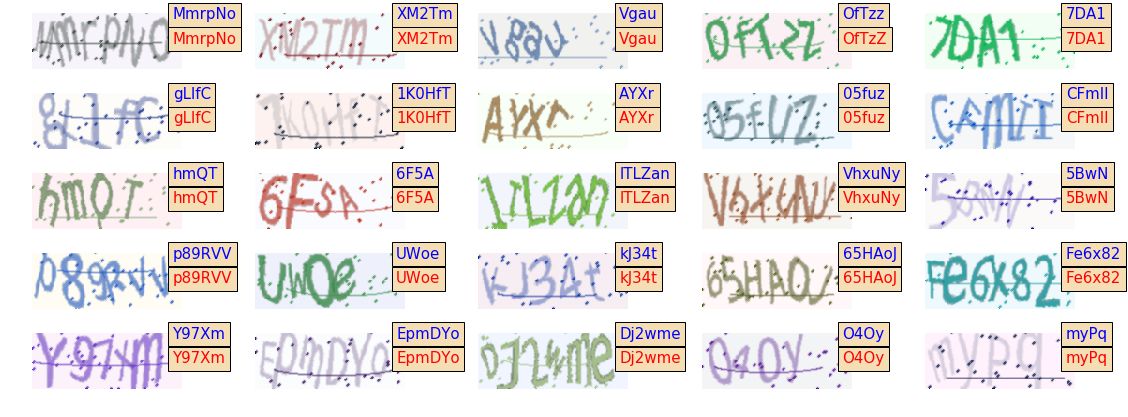

In [58]:
def draw_predict(img,y_pred):
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 14

    n = 5
    fig,axs = plt.subplots(nrows=n,ncols=n,sharex=True,sharey=True,figsize=(16,6))
    for i in range(n**2):
        ax = axs[i // n, i % n]
        ax.imshow(img[i].astype(np.uint8))
        ax.text(150,6,vec2text(y[i]),fontsize=15,color = 'blue',
                bbox=dict(boxstyle="square",facecolor='wheat'))
        ax.text(150,32,pred2text(y_pred[i]),fontsize=15,color = 'red',
                bbox=dict(boxstyle="square",facecolor='wheat'))
        
        ax.axis('off')
    plt.tight_layout()
    #fig.savefig(address_predict, dpi=300)
    plt.show()
    
model = model
model.load_weights(address_model)
[img,x,y] = Generate_Data().test()
y_pred = model.predict(x)
draw_predict(img,y_pred)